In [88]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import sys
sys.path.append('../src')

from spark import SparkSessionFactory, write_csv, read_csv, column_values, train_test_split, PageSet, get_columns, get_rows

from data import MovieLensDataSource
from util import create_path, remove_dir

import pyspark.sql.types as t
import pyspark.sql as s
import pyspark.sql.functions as f

# Recommedations dataset building

This is the first step of the process to train a model that predict an user rating to a given movie. Before all, we needs to build a table of features from a raw dataset. This table must be contain next columns:

**feature table columns**:
* **user_id**: This is a categorical column because this has discrete values one of for each user in raw dataset.
* **movie_id**: Like user_id column, this has discrete values one for each movie in raw dataset. 
* **one column for each movie genre**
  * For example: accion_genre, drama_gender, etc... are possible columns. Each one takes a discrete value 1 or 0.
  * Why is there one column by genre? Because, each movie could have one or more genres. 
* **rating**: Score that a user(user_id) gives to a movie(movie_id).

Finally, we have a table with discreate column values, they are also called categorical columns, because this columns only take one value from a finite list of possible values. An example of this table must be:

| user_id | movie_id | accion_genre | drama_genre | rating |
| --- | --- | --- | --- | --- |
| 1 |  1 | 1 | 0 | 5 |
| 1 |  2 | 0 | 1 | 1 |
| 1 |  3 | 1 | 1 | 3 |

* User 1 rated the movie 1 with a score of 5 points, because he loves accion movies.
* User 1 rated the movie 2 with a score of 1 points, because he is not interested to drama movies.
* User 1 rated the movie 3 with a score of 2 points, given that he loves accion but is not interested to drama.
* action_genre/drama_genre is a categorical column because only could take 1 or 0 values.
* user_id is categorical column because only could take any of user ids(Exist a discrte number of user ids).
* movie_id is categorical column because only could take any of movie ids(Exist a discrte number of user ids).

## Building out features table

**Step 1**: Let's to start create a new spark session.

In [90]:
session = SparkSessionFactory.create()
session

**Step 2**: Select a raw dataset size. For this recommendation examples we have 3 raw datasets each with distinct number of examples. Sometimes we need to begins with a tiny dataset to try to create a model that overfit to these data. This tell us that the model understand input patterns although this does not generalize yet but the model understand input patterns. The next step is maybe use more data and try to find the best hiperparameters so that the model generalize as well as possible.

In [91]:
print('Dataset sizes:', MovieLensDataSource.sizes())

Dataset sizes: ['ml-latest-small', 'ml-25m', 'ml-latest']


In [92]:
# dataset_size = 'ml-latest' # 250MB
# dataset_size = 'ml-25m' # 25MB
dataset_size = 'ml-latest-small' # 1MB

### Download dataset

**Step 3**: Fisrt let's check dataset files.

Check: [Movie lens datasets](https://grouplens.org/datasets/movielens/)

In [93]:
ds = MovieLensDataSource(size = dataset_size)

In [94]:
ds.file_paths()

['/home/adrian/.keras/datasets/ml-latest-small/ratings.csv',
 '/home/adrian/.keras/datasets/ml-latest-small/tags.csv',
 '/home/adrian/.keras/datasets/ml-latest-small/links.csv',
 '/home/adrian/.keras/datasets/ml-latest-small/movies.csv']

**Step 4**: Load ratings and movies files to a dataset for each one. 

In [95]:
ratings = read_csv(session, ds.file_paths()[0])
movies = read_csv(session, ds.file_paths()[3])

**Step 5**: Let's see ratings and movies schemas.

In [96]:
ratings.show(5, truncate=False)
ratings.printSchema()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |1      |4.0   |964982703|
|1     |3      |4.0   |964981247|
|1     |6      |4.0   |964982224|
|1     |47     |5.0   |964983815|
|1     |50     |5.0   |964982931|
+------+-------+------+---------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [97]:
movies.show(5, truncate=False)
movies.printSchema()

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [98]:
movies = movies \
    .where("movieId is not null and title is not null and genres is not null") \
    .where("movieId >= 1 and title != '' and genres != ''")

**Step 6**: Left join both tables by movieId and select rating score, userId, movieId and genres columns.

In [99]:
ratings = ratings \
    .join(movies, on='movieId', how="left") \
    .select(
        f.col('rating'),    
        f.col('userId').alias('user_id'), 
        f.col('movieId').alias('movie_id'), 
        f.col('genres')
    ) \
    .where("rating is not null and userId is not null and movieId is not null and genres is not null") \
    .where("rating >= 0 and userId >= 1 or movieId >= 1 and genres != ''")

ratings.limit(10).toPandas()

,rating,user_id,movie_id,genres
0,4.0,1,1,Adventure|Animation|Children|Comedy|Fantasy
1,4.0,1,3,Comedy|Romance
2,4.0,1,6,Action|Crime|Thriller
3,5.0,1,47,Mystery|Thriller
4,5.0,1,50,Crime|Mystery|Thriller
5,3.0,1,70,Action|Comedy|Horror|Thriller
6,5.0,1,101,Adventure|Comedy|Crime|Romance
7,4.0,1,110,Action|Drama|War
8,5.0,1,151,Action|Drama|Romance|War
9,5.0,1,157,Comedy|War


**Step 7**: Group by movie genres to show all genres combinations.

In [100]:
genres_count = ratings \
    .groupBy('genres') \
    .count() \
    .orderBy(f.column('count').desc())

genres_count.limit(10).toPandas()

,genres,count
0,Comedy,7196
1,Drama,6291
2,Comedy|Romance,3967
3,Comedy|Drama|Romance,3000
4,Comedy|Drama,2851
5,Drama|Romance,2838
6,Action|Adventure|Sci-Fi,2361
7,Crime|Drama,2315
8,Action|Crime|Thriller,1554
9,Action|Adventure|Thriller,1455


**Step 8**: Create genres column names:

In [101]:
def normalize(value): return value.lower().replace('-','_')

In [102]:
genres_columns = genres_count \
        .select('genres') \
        .rdd \
        .flatMap(lambda it: it[0].split('|')) \
        .distinct() \
        .map(lambda it: (it, 'gen_none' if '(' in it else f'gen_{normalize(it)}')) \
        .collect()

genres_columns

[('Comedy', 'gen_comedy'),
 ('Drama', 'gen_drama'),
 ('Romance', 'gen_romance'),
 ('Action', 'gen_action'),
 ('Adventure', 'gen_adventure'),
 ('Sci-Fi', 'gen_sci_fi'),
 ('Crime', 'gen_crime'),
 ('Thriller', 'gen_thriller'),
 ('War', 'gen_war'),
 ('Documentary', 'gen_documentary'),
 ('Mystery', 'gen_mystery'),
 ('IMAX', 'gen_imax'),
 ('Horror', 'gen_horror'),
 ('Children', 'gen_children'),
 ('Fantasy', 'gen_fantasy'),
 ('Animation', 'gen_animation'),
 ('Musical', 'gen_musical'),
 ('Film-Noir', 'gen_film_noir'),
 ('Western', 'gen_western'),
 ('(no genres listed)', 'gen_none')]

**Step 9**: create features table.

In [103]:
for (genre, col_name) in genres_columns:
    ratings = ratings.withColumn(col_name, ratings.genres.contains(genre).cast('integer'))

ratings = ratings.drop('genres')
    
ratings.limit(5).toPandas()

,rating,user_id,movie_id,gen_comedy,gen_drama,gen_romance,gen_action,gen_adventure,gen_sci_fi,gen_crime,...,gen_mystery,gen_imax,gen_horror,gen_children,gen_fantasy,gen_animation,gen_musical,gen_film_noir,gen_western,gen_none
0,4.0,1,1,1,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,0
1,4.0,1,3,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.0,1,6,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5.0,1,47,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5.0,1,50,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

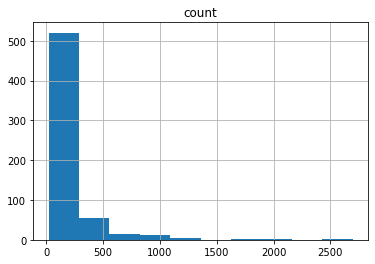

In [104]:
user_ratings_count = ratings \
    .groupBy('user_id') \
    .agg(f.count(f.column('user_id')).alias('count')) \
    .orderBy(f.column('count').desc())

user_ratings_count \
    .toPandas().hist('count')

Min and max number of user califications:

In [105]:
user_ratings_count \
    .agg(f.min('count'), f.max('count')) \
    .toPandas()

,min(count),max(count)
0,20,2698


array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

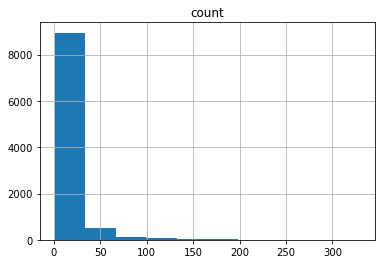

In [106]:
movie_ratings_count = ratings \
    .groupBy('movie_id') \
    .agg(f.count(f.column('movie_id')).alias('count')) \
    .orderBy(f.column('count').desc())

movie_ratings_count \
    .toPandas().hist('count')

In [107]:
movie_ratings_count \
    .agg(f.min('count'), f.max('count')) \
    .toPandas()

,min(count),max(count)
0,1,329


Get id of users who make 40 or more ratings:

In [108]:
user_ids = user_ratings_count \
    .where('count >= 20') \
    .select('user_id') \
    .rdd \
    .flatMap(lambda it: it) \
    .collect()

len(user_ids)

610

Movies with 40 or more ratings:

In [109]:
movie_ids = movie_ratings_count \
    .where('count >= 20') \
    .select('movie_id') \
    .rdd \
    .flatMap(lambda it: it) \
    .collect()

len(movie_ids)

1297

Filter samples for users who make 40 or more ratings and movies with 40 or more ratings:

In [110]:
ratings = ratings \
    .filter(ratings.user_id.isin(user_ids) | ratings.movie_id.isin(movie_ids))

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

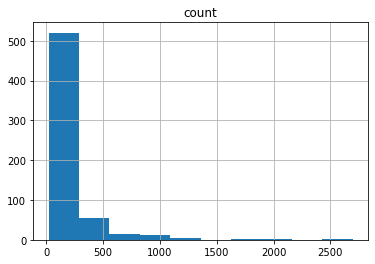

In [111]:
ratings \
    .groupBy('user_id') \
    .agg(f.count(f.column('user_id')).alias('count')) \
    .toPandas() \
    .hist('count')

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

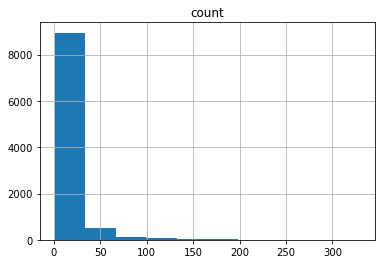

In [112]:
ratings \
    .groupBy('movie_id') \
    .agg(f.count(f.column('movie_id')).alias('count')) \
    .toPandas() \
    .hist('count')

**Step 10**: Write table a file.

In [113]:
TEMP_PATH = './temp'
DATASET_PATH = f'{TEMP_PATH}/dataset'

In [114]:
remove_dir(DATASET_PATH)
create_path(DATASET_PATH)

'./temp/dataset'

In [115]:
write_csv(ratings, DATASET_PATH)

In [116]:
session.stop()